# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
import itertools

import os

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from keras.utils.np_utils import to_categorical 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

from tqdm import tqdm, notebook
import time

# Read Data

In [31]:
train = pd.read_csv('./open data/train.csv')
test = pd.read_csv('./open data/test_x.csv')
train_copy = train.copy()
test_copy = test.copy()

In [37]:
def drop_outlier(data):
    outlier_id = np.where(data['familysize']>=100)[0]
    pdata = data.drop(outlier_id)
    
    return pdata

def drop_feature(data, drop):
    feature_arr = ['index','urban']
    """for i in range(20):
        featrue_arr.append('Q'+chr(i+97)+'E')"""
    for i in range(1,14):
        feature_arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        feature_arr.append(f'wf_{i:02d}')
    if drop:
        feature_arr.append('race')
            
    pdata = data.drop(feature_arr,axis=1)
    
    return pdata

def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,2,2,2,2],inplace=True)
    
    return pdata

def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[3,3,1,0,2,2,3,3,2,3,3,3],inplace=True)
    
    return pdata

def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata

def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

def family_band(data):
    pdata = data.copy()
    f_id = np.where(pdata['familysize']>=4)[0]
    for i in f_id:
        pdata.iloc[i,43]=4
    
    return pdata

def fill_married(data):
    pdata = data.copy()
    index = np.where(pdata['married']==0)[0]
    for i in index:
        if (pdata['age_group'][i]=='10s') or (pdata['age_group'][i]=='20s'):
            pdata.iloc[i,47] = 1
        else :
            pdata.iloc[i,47] = 2
    
    return pdata

def fill_education(data):
    pdata = data.copy()
    index = np.where(pdata['education']==0)[0]
    for i in index:
        if (pdata['age_group'][i]=='10s') :
            pdata.iloc[i,42] = 2
        else :
            pdata.iloc[i,42] = 3
    
    return pdata

def fill_engnat(data):
    pdata = data.copy()
    index = np.where(pdata['engnat']==0)[0]
    for i in index:
        pdata.iloc[i,43]
    
    return pdata

def Mach_score(data):
    pdata = data.copy()
    Answers = []
    for i in range(20):
        Answers.append('Q'+chr(97+i)+'A')
    reverse_col = ['QeA','QfA','QkA','QqA','QrA','QaA','QdA','QgA','QiA','QnA']
    for col in reverse_col:
        pdata[col] = -pdata[col]
    pdata['Mach_score'] = pdata[Answers].mean(axis=1)
    pdata = pdata.drop(Answers, axis=1)
    
    return pdata
    

In [38]:
def preprocess(data, drop, num_band, score=True):
    
    pdata = data.copy()
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = cat_num(pdata)
    pdata = E_band(pdata,num_band)
    pdata = drop_feature(pdata,drop)
    pdata = pdata.astype(np.float32)
    if score:
        pdata = Mach_score(pdata)
    
    return pdata

In [10]:
def submission_proba(test_data, model_arr,file_name):
    score = np.zeros((test_data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_data)
    pred = np.divide(score,num_model)[:,1]
    data = {'index':test_copy['index'],'voted':pred}
    submission = DataFrame(data)
    submission.to_csv('./submission/'+file_name+'.csv',index=False)
    
    return pred

In [7]:
def train_auc(model_arr, data, label):
    score = np.zeros((data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(data)
    pred = np.divide(score,num_model)[:,1]
    
    return roc_auc_score(label, pred)

# KFold 

# XGBoost

In [129]:
def xgb_pred_simple(num_model=6, max_depth=5, n_estimators=500, learning_rate=0.02, early_stopping=False):

    kfold = KFold(n_splits = num_model)
    model_arr = []
    i = 0
    for train_ids, test_ids in kfold.split(train_x,train_y):
        print('\033[41m'+f'Training {i}-th model'+'\033[0m')
        x_train, x_val = train_x.iloc[train_ids,:], train_x.iloc[test_ids,:]
        y_train, y_val = train_y.iloc[train_ids], train_y.iloc[test_ids]

        model = XGBClassifier(max_depth=max_depth,learning_rate=learning_rate, booster='gbtree',n_estimators=n_estimators, objective='binary:logistic')
        if early_stopping:
            model.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_val,y_val)], eval_metric='auc'
                     ,early_stopping_rounds=5
                     )
        else :
            model.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_val,y_val)], eval_metric='auc'
                 # ,early_stopping_rounds=5
                 )
        model_arr.append(model)
        i += 1
        
    file_name = f'xgb_{num_model}_{max_depth}_{n_estimators}_{learning_rate}_{early_stopping}'
    submission_proba(model_arr,file_name)
    print( train_auc(model_arr, train_x, train_y) )
    
    return model_arr

In [40]:
def xgb_pred(drop, num_band, num_model, max_depth, n_estimators, learning_rate):
    
    train_x = drop_outlier(train_copy)
    train_x = preprocess(train_x, drop, num_band)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    
    test_x = preprocess(test_copy, drop, num_band)
    
    
    kfold = KFold(n_splits = num_model)
    model_arr = []
    i = 0
    for train_ids, test_ids in kfold.split(train_x,train_y):
        # print('\033[41m'+f'Training {i}-th model'+'\033[0m')
        print(f'Training {i}-th model')
        x_train, x_val = train_x.iloc[train_ids,:], train_x.iloc[test_ids,:]
        y_train, y_val = train_y.iloc[train_ids], train_y.iloc[test_ids]

        model = XGBClassifier(max_depth=max_depth,learning_rate=learning_rate, booster='gbtree',n_estimators=n_estimators, objective='binary:logistic')
        model.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_val,y_val)], eval_metric='auc', verbose=False
             )
        model_arr.append(model)
        i += 1
        
    print( train_auc(model_arr, train_x, train_y) )
    
    file_name = f'xgb_True_{drop}_{num_band}_{num_model}_{max_depth}_{n_estimators}_{learning_rate}'
    submission_proba(test_x,model_arr,file_name)
    
    return model_arr

In [41]:
model_arr = xgb_pred(drop=False,num_band=10,num_model=6,max_depth=5,n_estimators=500,learning_rate=0.02)

Training 0-th model
Training 1-th model
Training 2-th model
Training 3-th model
Training 4-th model
Training 5-th model
0.8059512821751558


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

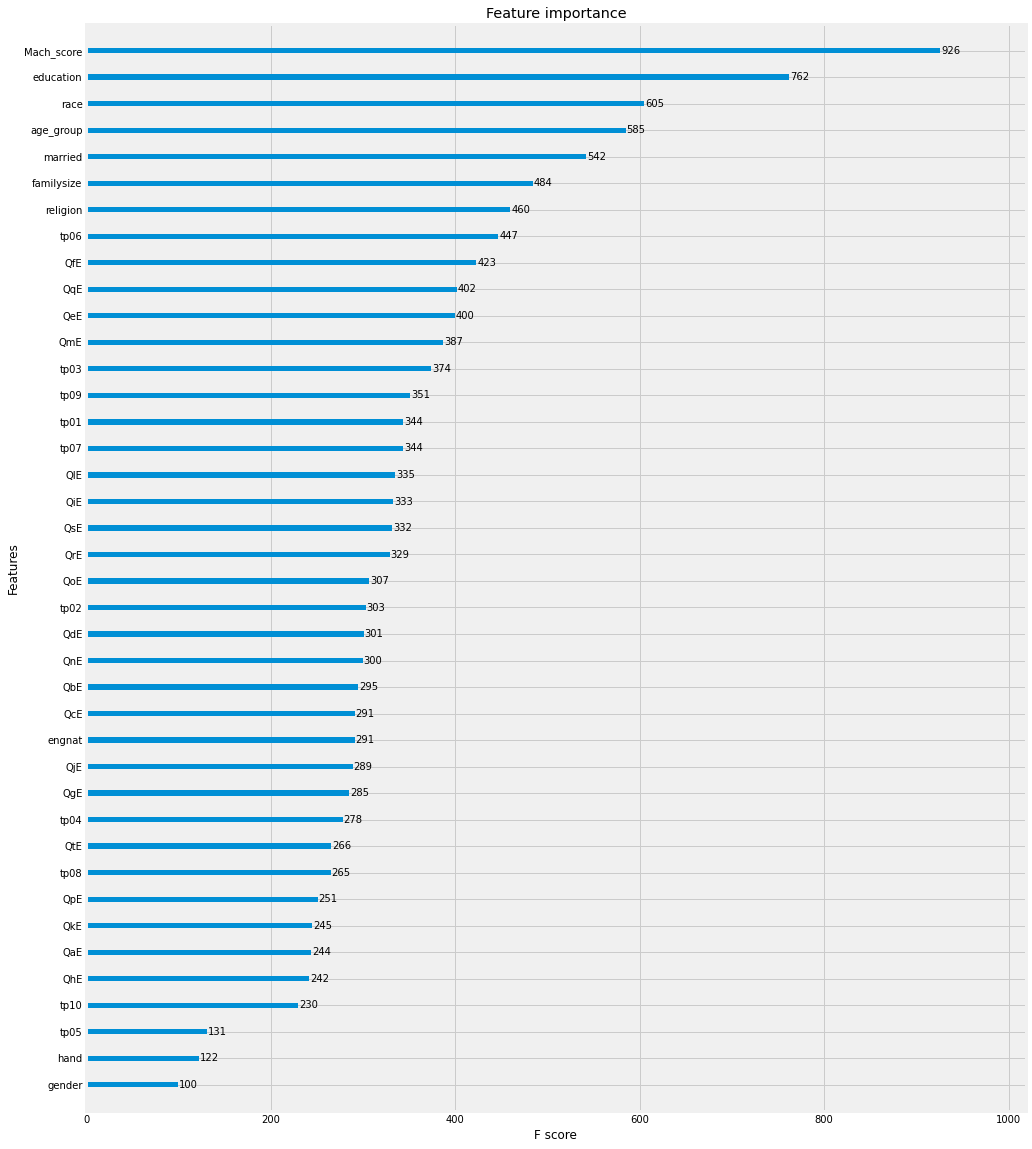

In [43]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(model_arr[0], ax=ax)

# LightGBM

In [239]:
num_model = 6
kfold = KFold(n_splits = num_model)
model_arr = []
i = 0
for train_ids, test_ids in kfold.split(train_x,train_y):
    print('\033[41m'+f'Training {i}-th model'+'\033[0m')
    x_train, x_val = train_x.iloc[train_ids,:], train_x.iloc[test_ids,:]
    y_train, y_val = train_y.iloc[train_ids], train_y.iloc[test_ids]
    
    model = LGBMClassifier(boosting_type='rf', num_leaves=60, max_depth=-1, 
                           n_estimators=200, min_child_samples=1000, subsample=0.7, subsample_freq=1, objective='binary')
    model.fit(x_train,y_train, eval_set=[(x_train,y_train),(x_val,y_val)], eval_metric='auc'
            #  ,early_stopping_rounds=5
             )
    model_arr.append(model)
    i += 1
    
submission_proba(model_arr,f'lgbm_{num_model}_fold')
train_auc(model_arr)

Training 0-th model
[1]	training's auc: 0.752831	training's binary_logloss: 0.579259	valid_1's auc: 0.748343	valid_1's binary_logloss: 0.581883
[2]	training's auc: 0.754153	training's binary_logloss: 0.578433	valid_1's auc: 0.749234	valid_1's binary_logloss: 0.581383
[3]	training's auc: 0.754186	training's binary_logloss: 0.578427	valid_1's auc: 0.749795	valid_1's binary_logloss: 0.581393
[4]	training's auc: 0.754368	training's binary_logloss: 0.578358	valid_1's auc: 0.74955	valid_1's binary_logloss: 0.581479
[5]	training's auc: 0.754621	training's binary_logloss: 0.578348	valid_1's auc: 0.750447	valid_1's binary_logloss: 0.581421
[6]	training's auc: 0.754544	training's binary_logloss: 0.578355	valid_1's auc: 0.749988	valid_1's binary_logloss: 0.581496
[7]	training's auc: 0.754549	training's binary_logloss: 0.578372	valid_1's auc: 0.749998	valid_1's binary_logloss: 0.581484
[8]	training's auc: 0.754646	training's binary_logloss: 0.578372	valid_1's auc: 0.750226	valid_1's binary_logloss

[79]	training's auc: 0.755725	training's binary_logloss: 0.578307	valid_1's auc: 0.750882	valid_1's binary_logloss: 0.581716
[80]	training's auc: 0.755733	training's binary_logloss: 0.57831	valid_1's auc: 0.750869	valid_1's binary_logloss: 0.581708
[81]	training's auc: 0.755714	training's binary_logloss: 0.57831	valid_1's auc: 0.750897	valid_1's binary_logloss: 0.581708
[82]	training's auc: 0.755728	training's binary_logloss: 0.578309	valid_1's auc: 0.750898	valid_1's binary_logloss: 0.581705
[83]	training's auc: 0.755746	training's binary_logloss: 0.578312	valid_1's auc: 0.750971	valid_1's binary_logloss: 0.581708
[84]	training's auc: 0.75573	training's binary_logloss: 0.578312	valid_1's auc: 0.750974	valid_1's binary_logloss: 0.581708
[85]	training's auc: 0.755714	training's binary_logloss: 0.578313	valid_1's auc: 0.750884	valid_1's binary_logloss: 0.581712
[86]	training's auc: 0.755726	training's binary_logloss: 0.578316	valid_1's auc: 0.750911	valid_1's binary_logloss: 0.581715
[87

[153]	training's auc: 0.75574	training's binary_logloss: 0.578345	valid_1's auc: 0.750896	valid_1's binary_logloss: 0.581722
[154]	training's auc: 0.755729	training's binary_logloss: 0.578345	valid_1's auc: 0.750912	valid_1's binary_logloss: 0.581722
[155]	training's auc: 0.755724	training's binary_logloss: 0.578347	valid_1's auc: 0.750909	valid_1's binary_logloss: 0.581724
[156]	training's auc: 0.755721	training's binary_logloss: 0.578346	valid_1's auc: 0.750908	valid_1's binary_logloss: 0.581724
[157]	training's auc: 0.755724	training's binary_logloss: 0.578345	valid_1's auc: 0.750885	valid_1's binary_logloss: 0.581727
[158]	training's auc: 0.755715	training's binary_logloss: 0.578345	valid_1's auc: 0.750888	valid_1's binary_logloss: 0.58173
[159]	training's auc: 0.755723	training's binary_logloss: 0.578345	valid_1's auc: 0.750862	valid_1's binary_logloss: 0.581733
[160]	training's auc: 0.755747	training's binary_logloss: 0.578337	valid_1's auc: 0.75082	valid_1's binary_logloss: 0.58

[26]	training's auc: 0.755211	training's binary_logloss: 0.578699	valid_1's auc: 0.751311	valid_1's binary_logloss: 0.580298
[27]	training's auc: 0.755168	training's binary_logloss: 0.578681	valid_1's auc: 0.751363	valid_1's binary_logloss: 0.580303
[28]	training's auc: 0.755651	training's binary_logloss: 0.578661	valid_1's auc: 0.751969	valid_1's binary_logloss: 0.580221
[29]	training's auc: 0.755628	training's binary_logloss: 0.578653	valid_1's auc: 0.752032	valid_1's binary_logloss: 0.580233
[30]	training's auc: 0.755415	training's binary_logloss: 0.57866	valid_1's auc: 0.752014	valid_1's binary_logloss: 0.580226
[31]	training's auc: 0.755452	training's binary_logloss: 0.578666	valid_1's auc: 0.752054	valid_1's binary_logloss: 0.580229
[32]	training's auc: 0.755616	training's binary_logloss: 0.578664	valid_1's auc: 0.752104	valid_1's binary_logloss: 0.580221
[33]	training's auc: 0.75559	training's binary_logloss: 0.578658	valid_1's auc: 0.752069	valid_1's binary_logloss: 0.580214
[3

[92]	training's auc: 0.755484	training's binary_logloss: 0.578688	valid_1's auc: 0.752299	valid_1's binary_logloss: 0.580214
[93]	training's auc: 0.755507	training's binary_logloss: 0.578685	valid_1's auc: 0.752292	valid_1's binary_logloss: 0.580214
[94]	training's auc: 0.755256	training's binary_logloss: 0.578671	valid_1's auc: 0.75232	valid_1's binary_logloss: 0.580188
[95]	training's auc: 0.755455	training's binary_logloss: 0.578669	valid_1's auc: 0.752341	valid_1's binary_logloss: 0.580187
[96]	training's auc: 0.755457	training's binary_logloss: 0.578673	valid_1's auc: 0.752358	valid_1's binary_logloss: 0.580186
[97]	training's auc: 0.755455	training's binary_logloss: 0.578674	valid_1's auc: 0.752299	valid_1's binary_logloss: 0.58019
[98]	training's auc: 0.75546	training's binary_logloss: 0.578667	valid_1's auc: 0.752315	valid_1's binary_logloss: 0.58017
[99]	training's auc: 0.755486	training's binary_logloss: 0.578665	valid_1's auc: 0.752345	valid_1's binary_logloss: 0.580164
[100

[167]	training's auc: 0.755468	training's binary_logloss: 0.578642	valid_1's auc: 0.752767	valid_1's binary_logloss: 0.580093
[168]	training's auc: 0.755467	training's binary_logloss: 0.578643	valid_1's auc: 0.752817	valid_1's binary_logloss: 0.58009
[169]	training's auc: 0.755458	training's binary_logloss: 0.578643	valid_1's auc: 0.752919	valid_1's binary_logloss: 0.580087
[170]	training's auc: 0.755446	training's binary_logloss: 0.578643	valid_1's auc: 0.752823	valid_1's binary_logloss: 0.580086
[171]	training's auc: 0.755434	training's binary_logloss: 0.578644	valid_1's auc: 0.752806	valid_1's binary_logloss: 0.580087
[172]	training's auc: 0.755434	training's binary_logloss: 0.578644	valid_1's auc: 0.752807	valid_1's binary_logloss: 0.580091
[173]	training's auc: 0.75543	training's binary_logloss: 0.578645	valid_1's auc: 0.752793	valid_1's binary_logloss: 0.580097
[174]	training's auc: 0.755429	training's binary_logloss: 0.578644	valid_1's auc: 0.752786	valid_1's binary_logloss: 0.5

[48]	training's auc: 0.755511	training's binary_logloss: 0.578425	valid_1's auc: 0.749263	valid_1's binary_logloss: 0.581415
[49]	training's auc: 0.755499	training's binary_logloss: 0.578426	valid_1's auc: 0.749284	valid_1's binary_logloss: 0.581408
[50]	training's auc: 0.755525	training's binary_logloss: 0.57841	valid_1's auc: 0.749306	valid_1's binary_logloss: 0.581392
[51]	training's auc: 0.755553	training's binary_logloss: 0.57841	valid_1's auc: 0.74935	valid_1's binary_logloss: 0.581379
[52]	training's auc: 0.755517	training's binary_logloss: 0.578409	valid_1's auc: 0.749335	valid_1's binary_logloss: 0.581377
[53]	training's auc: 0.755521	training's binary_logloss: 0.578404	valid_1's auc: 0.749367	valid_1's binary_logloss: 0.581373
[54]	training's auc: 0.755533	training's binary_logloss: 0.578393	valid_1's auc: 0.749266	valid_1's binary_logloss: 0.581367
[55]	training's auc: 0.755532	training's binary_logloss: 0.578389	valid_1's auc: 0.749313	valid_1's binary_logloss: 0.581355
[56

[119]	training's auc: 0.755768	training's binary_logloss: 0.578396	valid_1's auc: 0.749694	valid_1's binary_logloss: 0.581277
[120]	training's auc: 0.755742	training's binary_logloss: 0.578398	valid_1's auc: 0.749684	valid_1's binary_logloss: 0.581268
[121]	training's auc: 0.755758	training's binary_logloss: 0.578399	valid_1's auc: 0.74969	valid_1's binary_logloss: 0.581269
[122]	training's auc: 0.755766	training's binary_logloss: 0.578399	valid_1's auc: 0.749758	valid_1's binary_logloss: 0.581266
[123]	training's auc: 0.755775	training's binary_logloss: 0.578398	valid_1's auc: 0.749727	valid_1's binary_logloss: 0.581276
[124]	training's auc: 0.755767	training's binary_logloss: 0.5784	valid_1's auc: 0.749673	valid_1's binary_logloss: 0.58128
[125]	training's auc: 0.755747	training's binary_logloss: 0.5784	valid_1's auc: 0.749674	valid_1's binary_logloss: 0.581283
[126]	training's auc: 0.755769	training's binary_logloss: 0.5784	valid_1's auc: 0.749644	valid_1's binary_logloss: 0.581281


[186]	training's auc: 0.755873	training's binary_logloss: 0.578411	valid_1's auc: 0.749851	valid_1's binary_logloss: 0.581316
[187]	training's auc: 0.755866	training's binary_logloss: 0.578411	valid_1's auc: 0.749827	valid_1's binary_logloss: 0.581323
[188]	training's auc: 0.755865	training's binary_logloss: 0.578413	valid_1's auc: 0.749846	valid_1's binary_logloss: 0.581322
[189]	training's auc: 0.755847	training's binary_logloss: 0.578414	valid_1's auc: 0.749841	valid_1's binary_logloss: 0.581323
[190]	training's auc: 0.755856	training's binary_logloss: 0.578414	valid_1's auc: 0.749853	valid_1's binary_logloss: 0.58132
[191]	training's auc: 0.75589	training's binary_logloss: 0.57841	valid_1's auc: 0.749853	valid_1's binary_logloss: 0.581319
[192]	training's auc: 0.755879	training's binary_logloss: 0.57841	valid_1's auc: 0.749847	valid_1's binary_logloss: 0.581315
[193]	training's auc: 0.75587	training's binary_logloss: 0.578411	valid_1's auc: 0.749836	valid_1's binary_logloss: 0.5813

[54]	training's auc: 0.754842	training's binary_logloss: 0.578951	valid_1's auc: 0.755304	valid_1's binary_logloss: 0.578331
[55]	training's auc: 0.754827	training's binary_logloss: 0.578952	valid_1's auc: 0.755282	valid_1's binary_logloss: 0.578337
[56]	training's auc: 0.75481	training's binary_logloss: 0.578948	valid_1's auc: 0.755236	valid_1's binary_logloss: 0.578351
[57]	training's auc: 0.754903	training's binary_logloss: 0.578934	valid_1's auc: 0.755324	valid_1's binary_logloss: 0.578358
[58]	training's auc: 0.754901	training's binary_logloss: 0.57894	valid_1's auc: 0.755339	valid_1's binary_logloss: 0.578358
[59]	training's auc: 0.754913	training's binary_logloss: 0.57894	valid_1's auc: 0.755394	valid_1's binary_logloss: 0.578342
[60]	training's auc: 0.754902	training's binary_logloss: 0.578927	valid_1's auc: 0.755496	valid_1's binary_logloss: 0.578305
[61]	training's auc: 0.754957	training's binary_logloss: 0.578917	valid_1's auc: 0.755475	valid_1's binary_logloss: 0.578289
[62

[134]	training's auc: 0.755009	training's binary_logloss: 0.578984	valid_1's auc: 0.755706	valid_1's binary_logloss: 0.578247
[135]	training's auc: 0.755016	training's binary_logloss: 0.578984	valid_1's auc: 0.755685	valid_1's binary_logloss: 0.578246
[136]	training's auc: 0.755013	training's binary_logloss: 0.578981	valid_1's auc: 0.755654	valid_1's binary_logloss: 0.578253
[137]	training's auc: 0.755004	training's binary_logloss: 0.578982	valid_1's auc: 0.755673	valid_1's binary_logloss: 0.578249
[138]	training's auc: 0.755003	training's binary_logloss: 0.578979	valid_1's auc: 0.755672	valid_1's binary_logloss: 0.578253
[139]	training's auc: 0.754992	training's binary_logloss: 0.578978	valid_1's auc: 0.755693	valid_1's binary_logloss: 0.57825
[140]	training's auc: 0.755005	training's binary_logloss: 0.578979	valid_1's auc: 0.755681	valid_1's binary_logloss: 0.578245
[141]	training's auc: 0.754995	training's binary_logloss: 0.578977	valid_1's auc: 0.755668	valid_1's binary_logloss: 0.

[1]	training's auc: 0.751969	training's binary_logloss: 0.579748	valid_1's auc: 0.749202	valid_1's binary_logloss: 0.581709
[2]	training's auc: 0.752833	training's binary_logloss: 0.5794	valid_1's auc: 0.74847	valid_1's binary_logloss: 0.581652
[3]	training's auc: 0.753724	training's binary_logloss: 0.578888	valid_1's auc: 0.749232	valid_1's binary_logloss: 0.581096
[4]	training's auc: 0.754205	training's binary_logloss: 0.578758	valid_1's auc: 0.749733	valid_1's binary_logloss: 0.58098
[5]	training's auc: 0.754536	training's binary_logloss: 0.578657	valid_1's auc: 0.749908	valid_1's binary_logloss: 0.580832
[6]	training's auc: 0.754574	training's binary_logloss: 0.578678	valid_1's auc: 0.749908	valid_1's binary_logloss: 0.580774
[7]	training's auc: 0.754796	training's binary_logloss: 0.578672	valid_1's auc: 0.75012	valid_1's binary_logloss: 0.580679
[8]	training's auc: 0.754765	training's binary_logloss: 0.578667	valid_1's auc: 0.750248	valid_1's binary_logloss: 0.580665
[9]	training'

[79]	training's auc: 0.755401	training's binary_logloss: 0.578564	valid_1's auc: 0.750939	valid_1's binary_logloss: 0.580489
[80]	training's auc: 0.755331	training's binary_logloss: 0.578563	valid_1's auc: 0.750983	valid_1's binary_logloss: 0.580492
[81]	training's auc: 0.755327	training's binary_logloss: 0.57856	valid_1's auc: 0.75094	valid_1's binary_logloss: 0.580502
[82]	training's auc: 0.755339	training's binary_logloss: 0.578564	valid_1's auc: 0.750934	valid_1's binary_logloss: 0.580497
[83]	training's auc: 0.755379	training's binary_logloss: 0.578567	valid_1's auc: 0.750903	valid_1's binary_logloss: 0.580511
[84]	training's auc: 0.755383	training's binary_logloss: 0.578569	valid_1's auc: 0.750903	valid_1's binary_logloss: 0.580511
[85]	training's auc: 0.755392	training's binary_logloss: 0.578573	valid_1's auc: 0.750895	valid_1's binary_logloss: 0.580514
[86]	training's auc: 0.755382	training's binary_logloss: 0.57857	valid_1's auc: 0.750896	valid_1's binary_logloss: 0.580511
[87

[156]	training's auc: 0.755535	training's binary_logloss: 0.578553	valid_1's auc: 0.750931	valid_1's binary_logloss: 0.580529
[157]	training's auc: 0.755561	training's binary_logloss: 0.578549	valid_1's auc: 0.750961	valid_1's binary_logloss: 0.580532
[158]	training's auc: 0.755544	training's binary_logloss: 0.578549	valid_1's auc: 0.750941	valid_1's binary_logloss: 0.580532
[159]	training's auc: 0.755544	training's binary_logloss: 0.578551	valid_1's auc: 0.750945	valid_1's binary_logloss: 0.580532
[160]	training's auc: 0.755559	training's binary_logloss: 0.578551	valid_1's auc: 0.750957	valid_1's binary_logloss: 0.580532
[161]	training's auc: 0.755533	training's binary_logloss: 0.578548	valid_1's auc: 0.750911	valid_1's binary_logloss: 0.580529
[162]	training's auc: 0.755523	training's binary_logloss: 0.578549	valid_1's auc: 0.750877	valid_1's binary_logloss: 0.58053
[163]	training's auc: 0.755533	training's binary_logloss: 0.578549	valid_1's auc: 0.750892	valid_1's binary_logloss: 0.

[27]	training's auc: 0.75477	training's binary_logloss: 0.578816	valid_1's auc: 0.753541	valid_1's binary_logloss: 0.578894
[28]	training's auc: 0.754732	training's binary_logloss: 0.578828	valid_1's auc: 0.75366	valid_1's binary_logloss: 0.578923
[29]	training's auc: 0.754755	training's binary_logloss: 0.578826	valid_1's auc: 0.753617	valid_1's binary_logloss: 0.578956
[30]	training's auc: 0.754716	training's binary_logloss: 0.578833	valid_1's auc: 0.753555	valid_1's binary_logloss: 0.578979
[31]	training's auc: 0.754709	training's binary_logloss: 0.57884	valid_1's auc: 0.753678	valid_1's binary_logloss: 0.578974
[32]	training's auc: 0.754684	training's binary_logloss: 0.578847	valid_1's auc: 0.753708	valid_1's binary_logloss: 0.578984
[33]	training's auc: 0.754666	training's binary_logloss: 0.578834	valid_1's auc: 0.753716	valid_1's binary_logloss: 0.578946
[34]	training's auc: 0.754675	training's binary_logloss: 0.578835	valid_1's auc: 0.753709	valid_1's binary_logloss: 0.578962
[35

[105]	training's auc: 0.755097	training's binary_logloss: 0.578773	valid_1's auc: 0.753607	valid_1's binary_logloss: 0.578851
[106]	training's auc: 0.755102	training's binary_logloss: 0.578769	valid_1's auc: 0.753615	valid_1's binary_logloss: 0.578835
[107]	training's auc: 0.755096	training's binary_logloss: 0.578769	valid_1's auc: 0.753631	valid_1's binary_logloss: 0.578838
[108]	training's auc: 0.755126	training's binary_logloss: 0.578768	valid_1's auc: 0.753608	valid_1's binary_logloss: 0.578842
[109]	training's auc: 0.755117	training's binary_logloss: 0.578766	valid_1's auc: 0.75363	valid_1's binary_logloss: 0.578836
[110]	training's auc: 0.755125	training's binary_logloss: 0.578768	valid_1's auc: 0.753639	valid_1's binary_logloss: 0.578837
[111]	training's auc: 0.755121	training's binary_logloss: 0.578767	valid_1's auc: 0.753585	valid_1's binary_logloss: 0.578831
[112]	training's auc: 0.75511	training's binary_logloss: 0.578771	valid_1's auc: 0.753585	valid_1's binary_logloss: 0.5

[179]	training's auc: 0.755214	training's binary_logloss: 0.5788	valid_1's auc: 0.753785	valid_1's binary_logloss: 0.57883
[180]	training's auc: 0.755448	training's binary_logloss: 0.578786	valid_1's auc: 0.754027	valid_1's binary_logloss: 0.578822
[181]	training's auc: 0.755446	training's binary_logloss: 0.578787	valid_1's auc: 0.754016	valid_1's binary_logloss: 0.578825
[182]	training's auc: 0.755454	training's binary_logloss: 0.578787	valid_1's auc: 0.75402	valid_1's binary_logloss: 0.57882
[183]	training's auc: 0.755443	training's binary_logloss: 0.578786	valid_1's auc: 0.754017	valid_1's binary_logloss: 0.578824
[184]	training's auc: 0.75544	training's binary_logloss: 0.578789	valid_1's auc: 0.753996	valid_1's binary_logloss: 0.578829
[185]	training's auc: 0.755446	training's binary_logloss: 0.57879	valid_1's auc: 0.754009	valid_1's binary_logloss: 0.578834
[186]	training's auc: 0.755445	training's binary_logloss: 0.578792	valid_1's auc: 0.753992	valid_1's binary_logloss: 0.578835

0.7558124087370248